In [11]:
!sudo apt-get install -y fonts-nanum 
!sudo fc-cache -fv 
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [12]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt 
plt.rc('font', family='NanumBarunGothic')

In [13]:
df=pd.read_csv('pretest_data.csv')

In [14]:
df.index=pd.to_datetime(df['published_date']).values #인덱스를 날짜 데이터로 변경
week_df_list = [g for n,g in df.groupby(pd.Grouper(freq='W'))] #주별로 데이터프레임을 분리 및 리스트화
month_df_list = [g for n,g in df.groupby(pd.Grouper(freq='M'))] #월별로 데이터를 분리 및 리스트화
YM_list=df['published_date'].apply(lambda x : x[:-3]).drop_duplicates().values
YM_list.sort() #데이터의 년월 정보를 리스트화

category_list=df['category_name'].unique()
category_color_list=['lightcoral','mistyrose','gold','darkkhaki','chartreuse','lightseagreen','deepskyblue','lightslategray','cornflowerblue','mediumblue','blueviolet','fuchsia','mediumvioletred','lightpink','gray']
category_dic={a:b for a,b in zip(category_list,category_color_list)}

# Q1. 데이터 타입별 시각화(자유양식)

###  전체기간 카테고리 -> 채널 -> 비디오 개수

In [15]:
df_g_ca_id=df.groupby(['category_name','channel_id']).size().to_frame()
df_g_ca_n=df_g_ca_id.groupby('category_name').size().to_frame()
df_g_ca=df.groupby(['category_name']).size().to_frame()

df_g_ca[1]=df_g_ca_n # 0: category_total 1: chennel_count
df_g_ca=df_g_ca.sort_values(0,ascending=False)

In [16]:
names=df_g_ca_n.sort_values(0,ascending=False).index
df_s=None
for ids,name in enumerate(names):
  df_c=df_g_ca_id.loc[name].T
  df_c.columns=range(len(df_c.columns))
  drop_c=[x for x in df_c.columns if df_c[x][0]<1]
  df_c=df_c.drop(drop_c,axis=1)
  df_c.columns=range(len(df_c.columns))
  if ids:
    df_s=pd.concat([df_s,df_c])
  else:
    df_s=df_c
df_s.index=names.values

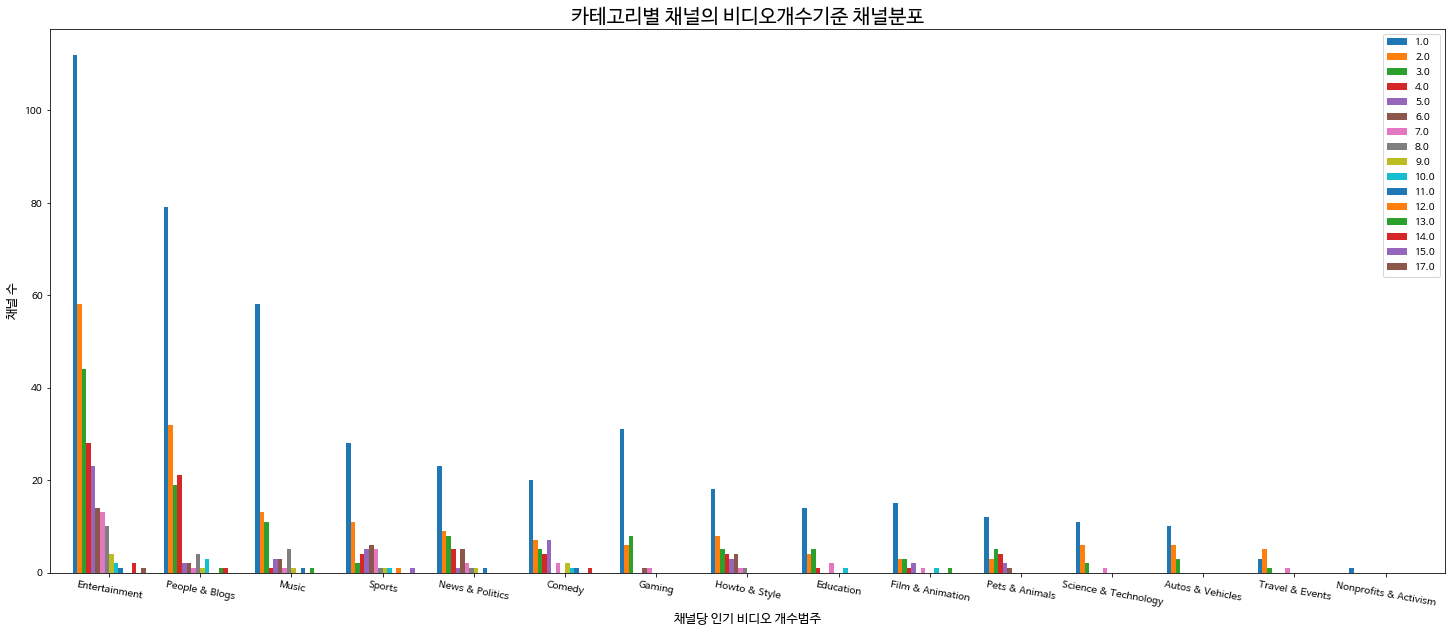

In [17]:
#Q1. 전체기간 카테고리 -> 채널 -> 비디오 개수 (ver.1)

df_total=None
for num,idx in enumerate(df_s.index):
  df_sub=df_s.loc[idx].value_counts().to_frame().sort_index().T
  if num:
    df_total=pd.concat([df_total,df_sub])
  else:
    df_total=df_sub
df_total=df_total.fillna(0)

df_total.plot(kind='bar',figsize=(25,10),width=0.8)
plt.title('카테고리별 채널의 비디오개수기준 채널분포',fontsize=20)
plt.ylabel('채널 수',fontsize=13)
plt.xlabel('채널당 인기 비디오 개수범주',fontsize=13)
plt.xticks(rotation=350)
plt.show()

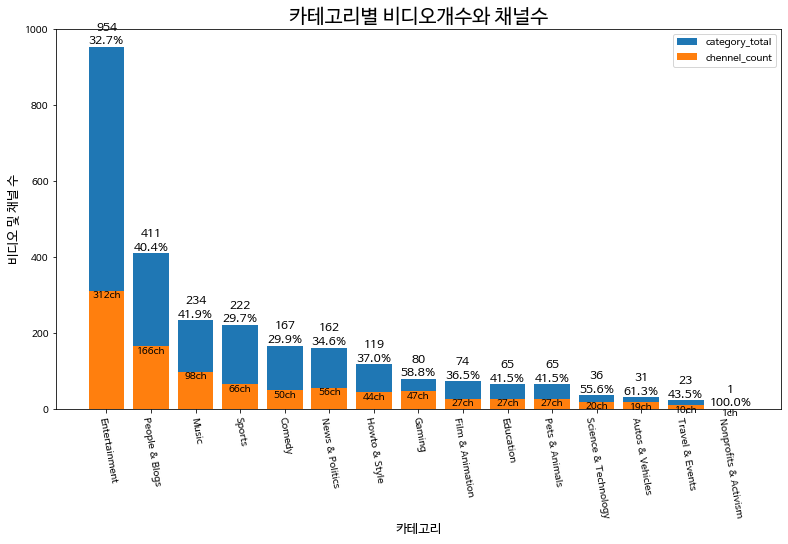

In [18]:
#Q1. 전체기간 카테고리 -> 채널 -> 비디오 개수 (ver.2)

plt.figure(figsize=(13,7))
p1=plt.bar(df_g_ca.index,df_g_ca[0])
p2=plt.bar(df_g_ca.index,df_g_ca[1])

plt.legend((p1[0],p2[0]),('category_total','chennel_count'))
plt.xticks(rotation=280)

plt.title('카테고리별 비디오개수와 채널수',fontsize=20)
plt.ylabel('비디오 및 채널 수',fontsize=13)
plt.xlabel('카테고리',fontsize=13)

for rect,rect2,num,num2 in zip(p1,p2,df_g_ca[0],df_g_ca[1]):
  plt.text(rect.get_x()+rect.get_width()/2,rect.get_y()+rect.get_height(),f'{num}\n{round(num2/num*100,1)}%',ha='center',va='bottom',fontsize=12)
  plt.text(rect2.get_x()+rect2.get_width()/2,rect2.get_y()+rect2.get_height(),f'{num2}ch',ha='center',va='top',fontsize=10)

### 월별 카테고리 -> 채널 -> 비디오 개수

In [19]:
df_category_dic=dict()

for num,sub in enumerate(month_df_list): #월별 데이터프레임 분배
  category_list=sub.category_name.unique()
  sub=sub.groupby(['category_name','channel_id']).count()[['video_id']]
  sub.columns=['채널 수']
  for category in set(a[0] for a in sub.index): #카테고리별 채널 비디오 분류
    sub2=sub.loc[category].value_counts()
    sub2=pd.DataFrame(sub2.values,index=sub2.index,columns=[YM_list[num]]).T
    if category in df_category_dic:
      df_category_dic[category]=pd.concat([df_category_dic[category],sub2])
    else:
      df_category_dic[category]=sub2

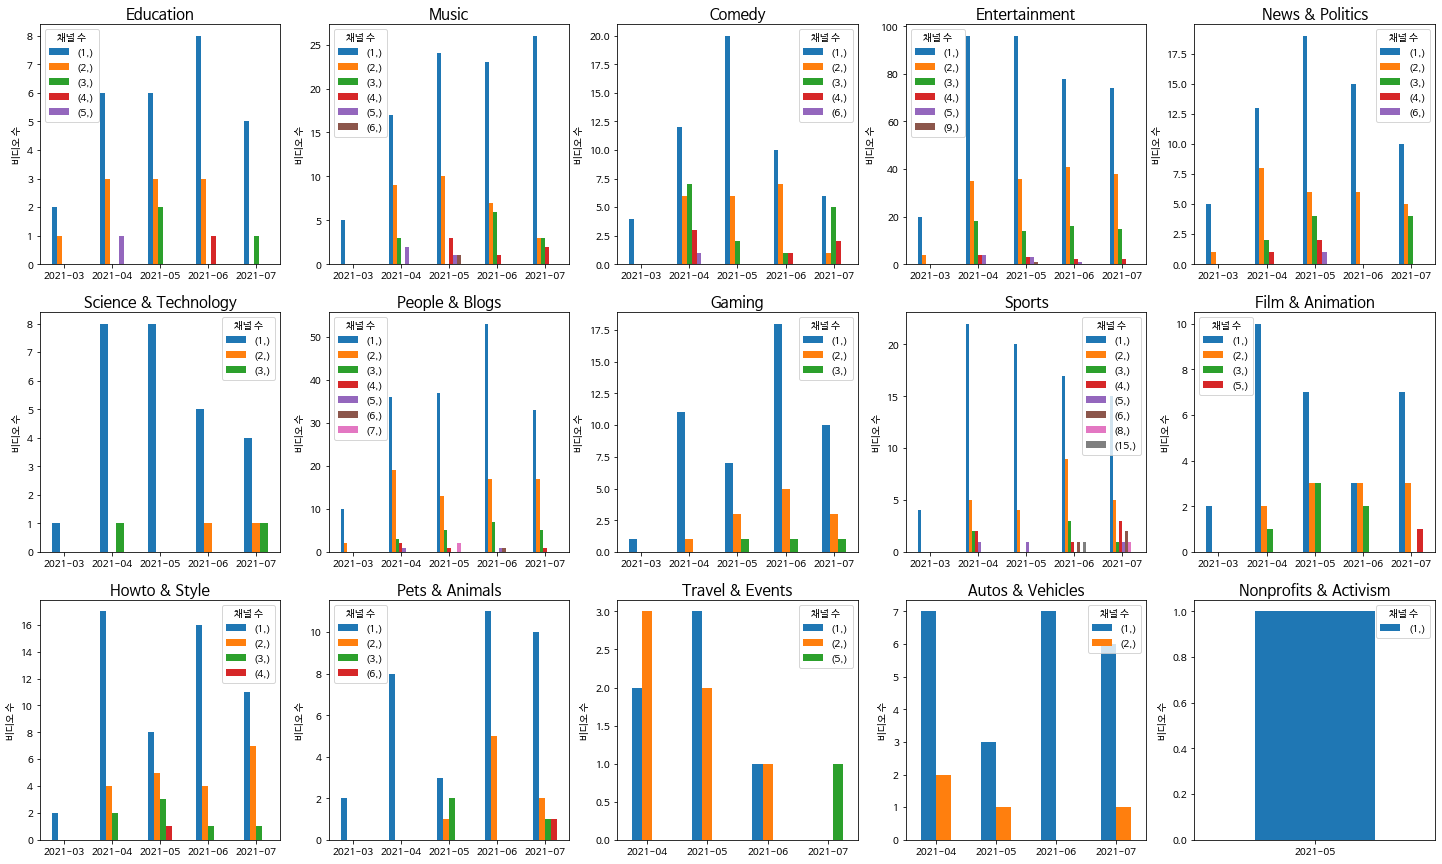

In [20]:
plt.figure(figsize=(25,15)) #카테고리별 시각화
for num,category in enumerate(df_category_dic):
  plt.subplot(3,5,num+1)
  df_category_dic[category].plot(kind='bar',ax=plt.gca())
  plt.xticks(rotation=360)
  plt.title(f'{category}',fontsize=15)
  plt.ylabel('비디오 수',fontsize=10)

plt.show()

### 월별 TOP10 채널(분류 기준은 비디오 개수)

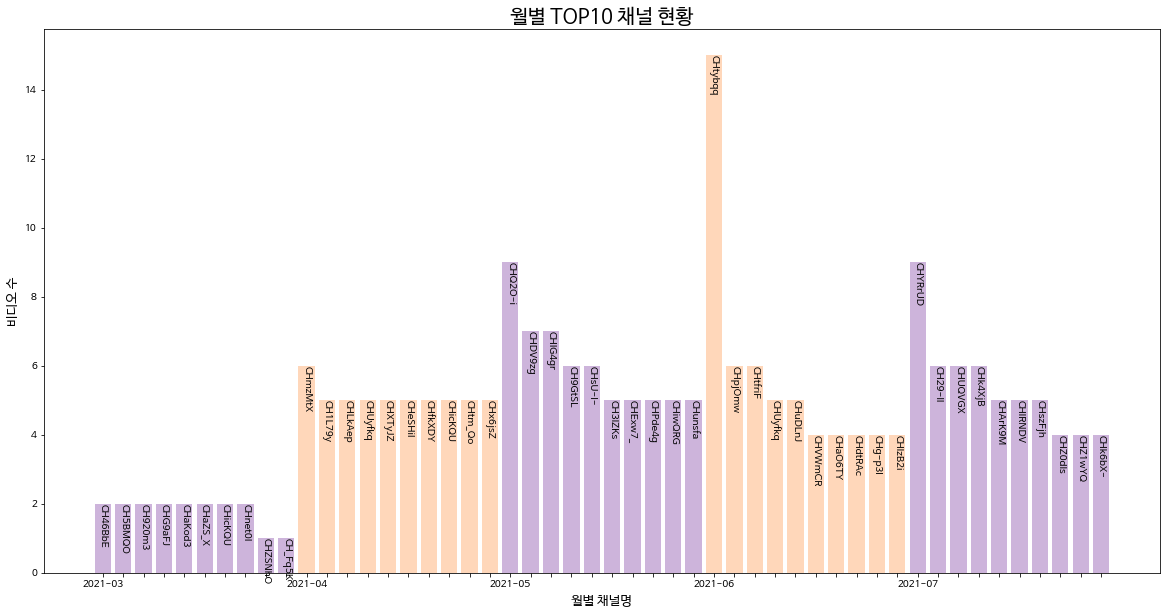

In [21]:
#월별 TOP10 채널(비디오 개수 기준)
VIEW_COUNT=10

df_best=df.copy()
df_best['published_date']=df_best['published_date'].apply(lambda x : x[:-3])
df_best=df_best[['published_date','channel_id','video_id']].groupby(['published_date','channel_id']).count()

df_best10=None
for num,date in enumerate(YM_list):
  df_best_sub=df_best.loc[date].sort_values('video_id',ascending=False).head(10)
  df_best_sub['date']=[date]*10
  df_best_sub=df_best_sub.groupby(['date','channel_id']).sum().sort_values('video_id',ascending=False)
  if num:
    df_best10=pd.concat([df_best10,df_best_sub])
  else:
    df_best10=df_best_sub
df_best10

plt.figure(figsize=(20,10))
p1=plt.bar([" "*num if (num)%VIEW_COUNT else str(a[0][:]) for num,a in enumerate(df_best10.index.to_list())],[a[0] for a in df_best10.values], color=['#cdb4db']*VIEW_COUNT+['#ffd7ba']*VIEW_COUNT)
plt.xticks(rotation=360)

plt.title('월별 TOP10 채널 현황',fontsize=20)
plt.ylabel('비디오 수',fontsize=13)
plt.xlabel('월별 채널명',fontsize=13)

for rect,tag in zip(p1,df_best10.index):
  plt.text(rect.get_x()+rect.get_width()/2,rect.get_y()+rect.get_height(),f'{tag[1]}',ha='center',va='top',fontsize=10,rotation = 270)
plt.show()

### 주별 TOP5 채널 (분류 기준은 비디오 개수)

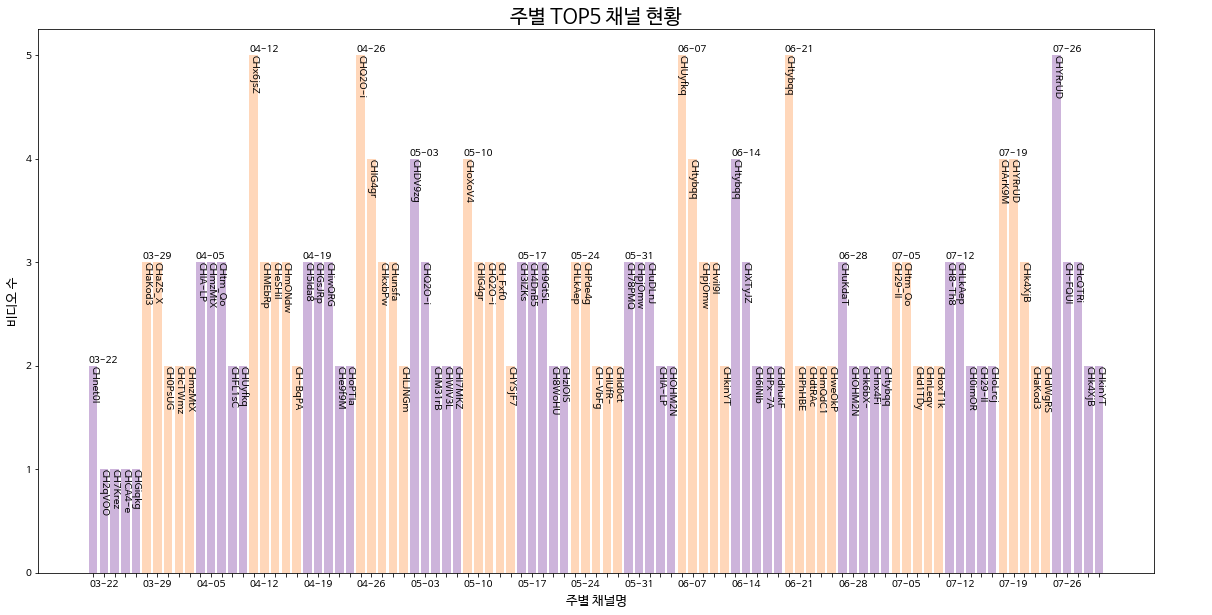

In [22]:
week_M=(df.resample('W-Mon').count().index-timedelta(days=7)).astype('str').values # 주별 날짜중 월요일 날짜를 생성
VIEW_COUNT=5

df_week=None
for num,(df_week_sub,w) in enumerate(zip(week_df_list,week_M)):
  df_week_sub=df_week_sub.groupby('channel_id').count()[['video_id']].sort_values('video_id',ascending=False)
  df_week_sub=df_week_sub.head(VIEW_COUNT)
  df_week_sub['date']=[w]*VIEW_COUNT
  df_week_sub=df_week_sub.groupby(['date','channel_id']).sum().sort_values('video_id',ascending=False)
  if num:
    df_week=pd.concat([df_week,df_week_sub])
  else:
    df_week=df_week_sub


plt.figure(figsize=(20,10))
p1=plt.bar([" "*num if (num+4)%VIEW_COUNT else str(a[0][5:]) for num,a in enumerate(df_week.index.to_list())],[a[0] for a in df_week.values], color=['#cdb4db']*VIEW_COUNT+['#ffd7ba']*VIEW_COUNT)
plt.xticks(rotation=360)

plt.title('주별 TOP5 채널 현황',fontsize=20)
plt.ylabel('비디오 수',fontsize=13)
plt.xlabel('주별 채널명',fontsize=13)

for num,(rect,tag) in enumerate(zip(p1,df_week.index)):
  plt.text(rect.get_x()+rect.get_width()/2,rect.get_y()+rect.get_height(),f'{tag[1]}',ha='center',va='top',fontsize=10,rotation = 270)
  if num%VIEW_COUNT==0:
    plt.text(rect.get_x(),rect.get_y()+rect.get_height(),f'{df_week.index[num][0][5:]}',ha='left',va='bottom',fontsize=10,rotation = 360)
plt.show()

### 월별 카테고리별 태그 키워드 순위

In [23]:
CATEGORY=df.category_name.unique()
df_tags_name=None
df_tags_count=None
df_tags=None
for num,m in enumerate(month_df_list):
  m=m.dropna()
  df_sub=None
  df_sub2=None
  for num2,C in enumerate(CATEGORY):
    tags=[]
    sub=m[m['category_name']==C]
    for n in range(sub.shape[0]):
      tags_sub=sub.iloc[n]['tags'].split('|') #tags 데이터의 토큰화 진행
      tags_sub=set(tags_sub+[a for x in tags_sub if len(x.split())>1 for a in x.split()]) #tag들을 띄어쓰기 구분 토큰화 및 한 영상내 중복 토큰 제거
      tags+=list(tags_sub) #한 카테고리내 tags 정보 종합
    count=min(5,len(tags)) # 종합된 카테고리 개수가 5를 넘는지 확인
    tags=pd.Series(tags,name=C).value_counts()[:5]

    tags=tags.to_frame()
    names=tags.index.to_frame()
    tags=pd.DataFrame(tags.T.values,index=[YM_list[num]],columns=[f'{C}{n}'for n in range(1,count+1)]) #tags 랭크 정보를 프레임화 (등장 횟수)
    names=pd.DataFrame(names.T.values,index=[YM_list[num]],columns=[f'{C}{n}'for n in range(1,count+1)]) #tags 랭크정보를 프레임화 (토큰 이름)
    #데이터 프레임 정보 쌓기
    if num2:
      df_sub=pd.concat([df_sub,tags],axis=1)
      df_sub2=pd.concat([df_sub2,names],axis=1)
    else:
      df_sub=tags
      df_sub2=names
  if num:
    df_tags_count=pd.concat([df_tags_count,df_sub])
    df_tags_name=pd.concat([df_tags_name,df_sub2])
  else:
    df_tags_count=df_sub
    df_tags_name=df_sub2
    
df_tags_name=df_tags_name.fillna('')
df_tags_count=df_tags_count.fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 246 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 246 missing from current font.
  font.set_text(s, 0, flags=flags)


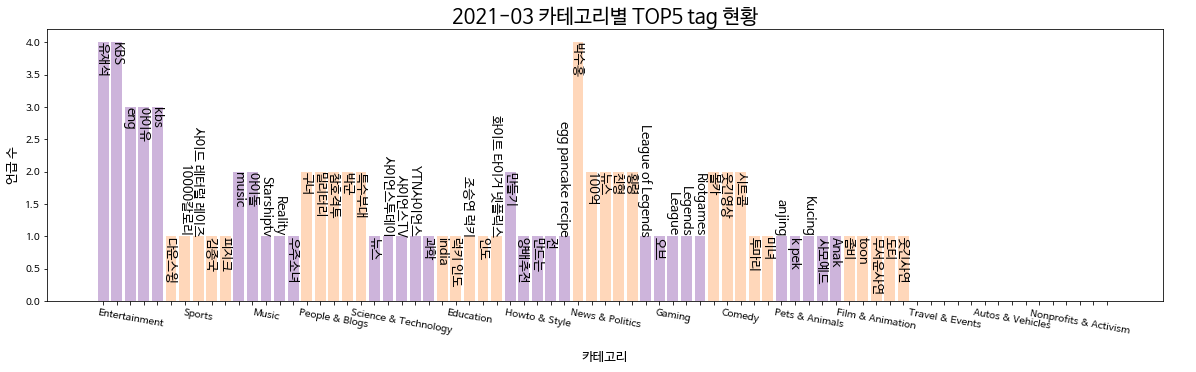

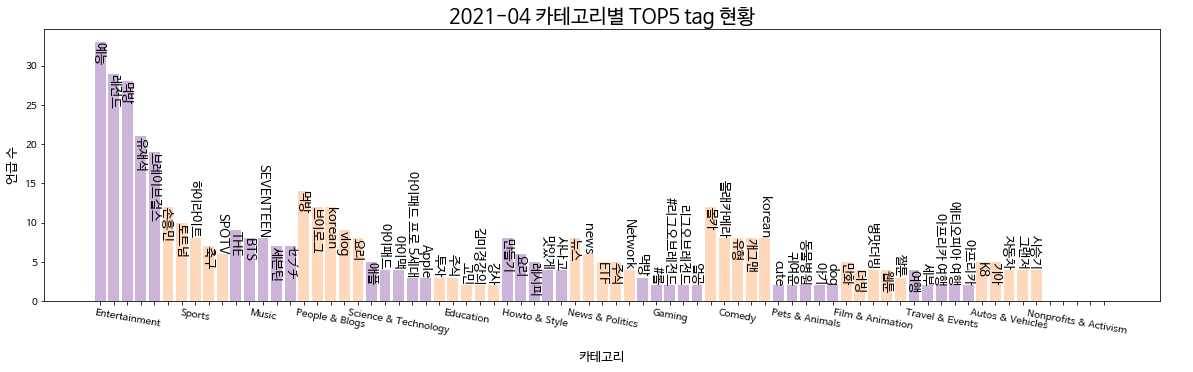

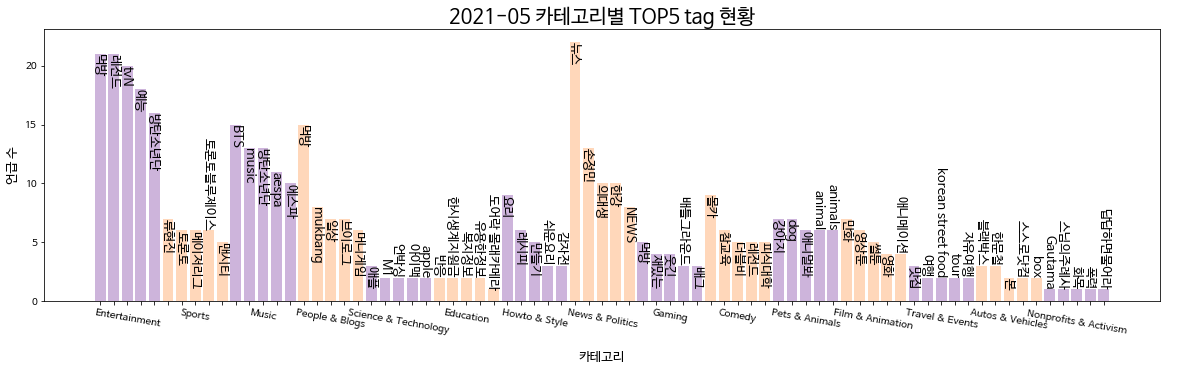

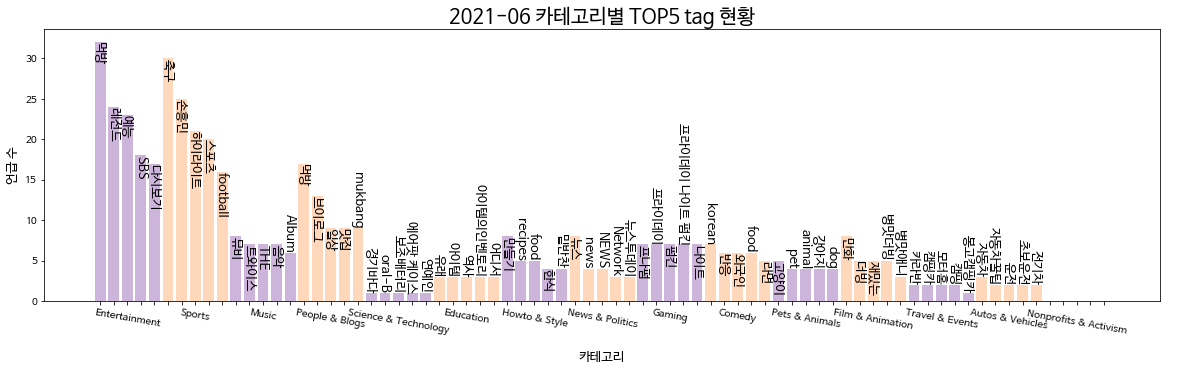

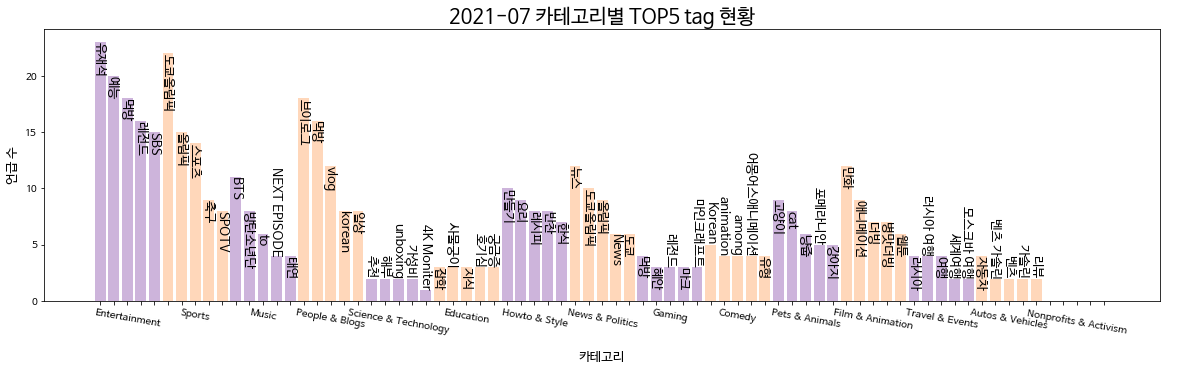

In [24]:
VIEW_COUNT=5

for n in range(df_tags_count.shape[0]):
  plt.figure(figsize=(20,5))
  
  #그래프 생성 및 조정
  p1=plt.bar([" "*num if (num+3)%VIEW_COUNT else str(a[:-1]) for num,a in enumerate(df_tags_count.columns.to_list())],df_tags_count.iloc[n],color=['#cdb4db']*5+['#ffd7ba']*5)
  plt.xticks(rotation=350)

  plt.title(f'{df_tags_count.index[n]} 카테고리별 TOP5 tag 현황',fontsize=20)
  plt.ylabel('언급 수',fontsize=13)
  plt.xlabel('카테고리',fontsize=13)

  for num,(rect,tag) in enumerate(zip(p1,df_tags_name.iloc[n])): #텍스트 출력 내용 및 방식 설정
    if df_tags_count.iloc[n].iloc[num]>=len(df_tags_name.iloc[n].iloc[num])*(df_tags_count.iloc[n].max()/20):
      plt.text(rect.get_x()+rect.get_width()/2.5,rect.get_y()+rect.get_height(),f'{tag}',ha='center',va='top',fontsize=13,rotation = 270)
    else:
      plt.text(rect.get_x()+rect.get_width()/2.5,rect.get_y()+rect.get_height(),f'{tag}',ha='center',va='bottom',fontsize=13,rotation = 270)
  plt.show()

# Q2. 호응도(engagement)를 판단할수 있는 객관적인 지표 기반 새로운 지표 개발

In [25]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 360 kB/s 


In [26]:
import xgboost
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from xgboost import XGBRegressor,XGBClassifier
from sklearn.pipeline import make_pipeline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [27]:
df4=df.copy()
df4['published_days']=(pd.to_datetime(df4['on_trending_date'])-pd.to_datetime(df4['published_date'])).astype(str)
df4['published_days']=df4['published_days'].apply(lambda x : int(x[:-4]))
df4=df4[['category_name','on_rank','on_views','on_likes','on_dislikes','on_comments','on_channel_subscribers','on_channel_total_views','on_channel_total_videos','published_days']]
#df4['tags']=df4['tags'].fillna('None').apply(lambda x : ' '.join(x.split('|')))
df4=df4.sort_index()
df4.shape

(2644, 10)

In [28]:
TRAIN_SIZE=int(df4.shape[0]*.8)
df4=OrdinalEncoder().fit_transform(df4)

train = df4.iloc[:TRAIN_SIZE]
test = df4.iloc[TRAIN_SIZE:]

train_x, train_y = train.drop('on_rank',axis=1),train['on_rank']
test_x, test_y = test.drop('on_rank',axis=1),test['on_rank']

In [29]:
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.08, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=10)
eval_set=[(train_x,train_y),(test_x,test_y)]

xgb_model.fit(train_x, train_y,eval_set=eval_set,early_stopping_rounds=100,eval_metric='mae')

[12:14:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:18.4187	validation_1-mae:17.6823
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:17.046	validation_1-mae:16.3867
[2]	validation_0-mae:15.7946	validation_1-mae:15.2242
[3]	validation_0-mae:14.6675	validation_1-mae:14.2919
[4]	validation_0-mae:13.6422	validation_1-mae:13.4859
[5]	validation_0-mae:12.7029	validation_1-mae:12.7994
[6]	validation_0-mae:11.8682	validation_1-mae:12.2457
[7]	validation_0-mae:11.1075	validation_1-mae:11.7592
[8]	validation_0-mae:10.4209	validation_1-mae:11.3426
[9]	validation_0-mae:9.79047	validation_1-mae:10.9666
[10]	validation_0-mae:9.23711	validation_1-mae:10.6886
[11]	validation_0-mae:8.73269	validation_1-mae:10.4476
[12]	validation_0-mae:8.28479	validation_1-mae:10.2386
[13]	valida

XGBRegressor(learning_rate=0.08, max_depth=10, n_estimators=500, subsample=0.75)

In [30]:
model=XGBClassifier(n_estimators=500,
              random_state=2,
              n_jobs=-1,
              max_depth=5,
              learning_rate=0.08
            )


model.fit(train_x, train_y,eval_set=eval_set,eval_metric='merror',early_stopping_rounds=100)

[0]	validation_0-merror:0.810402	validation_1-merror:0.943289
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 100 rounds.
[1]	validation_0-merror:0.770213	validation_1-merror:0.941399
[2]	validation_0-merror:0.730024	validation_1-merror:0.939508
[3]	validation_0-merror:0.707801	validation_1-merror:0.941399
[4]	validation_0-merror:0.692199	validation_1-merror:0.937618
[5]	validation_0-merror:0.67896	validation_1-merror:0.943289
[6]	validation_0-merror:0.651537	validation_1-merror:0.94707
[7]	validation_0-merror:0.634988	validation_1-merror:0.950851
[8]	validation_0-merror:0.623168	validation_1-merror:0.943289
[9]	validation_0-merror:0.604728	validation_1-merror:0.94896
[10]	validation_0-merror:0.582033	validation_1-merror:0.941399
[11]	validation_0-merror:0.566903	validation_1-merror:0.941399
[12]	validation_0-merror:0.55461	validation_1-merror:0.941399
[13]	validation_0-merror:0.5375

XGBClassifier(learning_rate=0.08, max_depth=5, n_estimators=500, n_jobs=-1,
              objective='multi:softprob', random_state=2)

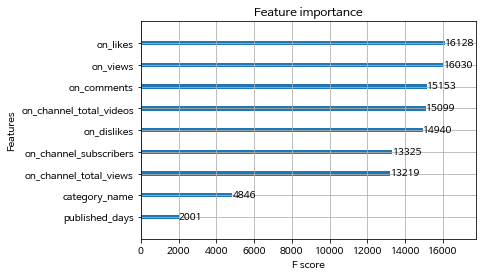

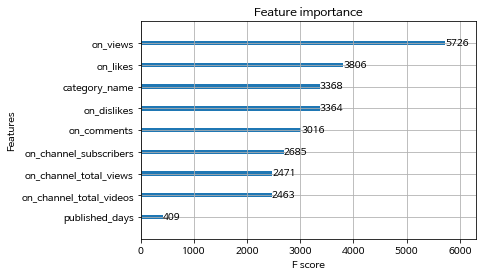

In [31]:
xgboost.plot_importance(model)
xgboost.plot_importance(xgb_model)

In [32]:
pred_Reg=xgb_model.predict(df4.drop('on_rank',axis=1))
pred_class=model.predict(df4.drop('on_rank',axis=1))
pred_set=(pred_Reg+pred_class)/2

In [33]:
df4['engagement_rank']=pred_set
df4.head(10)

,category_name,on_rank,on_views,on_likes,on_dislikes,on_comments,on_channel_subscribers,on_channel_total_views,on_channel_total_videos,published_days,engagement_rank
2021-03-25,1,1,8553414,825421,9096,47712,22200000,19311654452,14209,2,2.121344
2021-03-26,1,5,572113,9566,228,522,419000,31302574,76,2,6.655338
2021-03-26,2,19,275624,15272,35,2233,105000,5562950,19,2,19.233964
2021-03-26,3,10,1262201,69464,271,14729,1830000,380182956,573,2,10.246160
2021-03-26,1,28,1121118,31266,270,3499,1110000,126619182,86,2,23.558397
2021-03-27,1,4,599075,19047,415,6278,893000,196496420,132,2,6.938976
2021-03-27,4,13,1101249,3503,285,474,138000,173481297,337,2,12.530604
2021-03-27,2,28,106471,2433,22,780,109000,13299559,153,2,27.430343
2021-03-27,4,28,139114,2036,34,127,254000,48264340,283,3,27.633644
2021-03-27,5,16,445927,4930,296,565,555000,150769748,310,2,16.406825


In [34]:
!pip install shap

     |████████████████████████████████| 564 kB 4.2 MB/s 


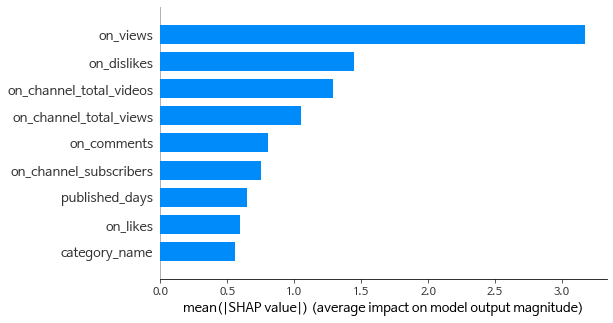

In [39]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(test_x)
shap.initjs()
shap.summary_plot(shap_values, test_x.iloc[:100], plot_type="bar",plot_size=(8,5))

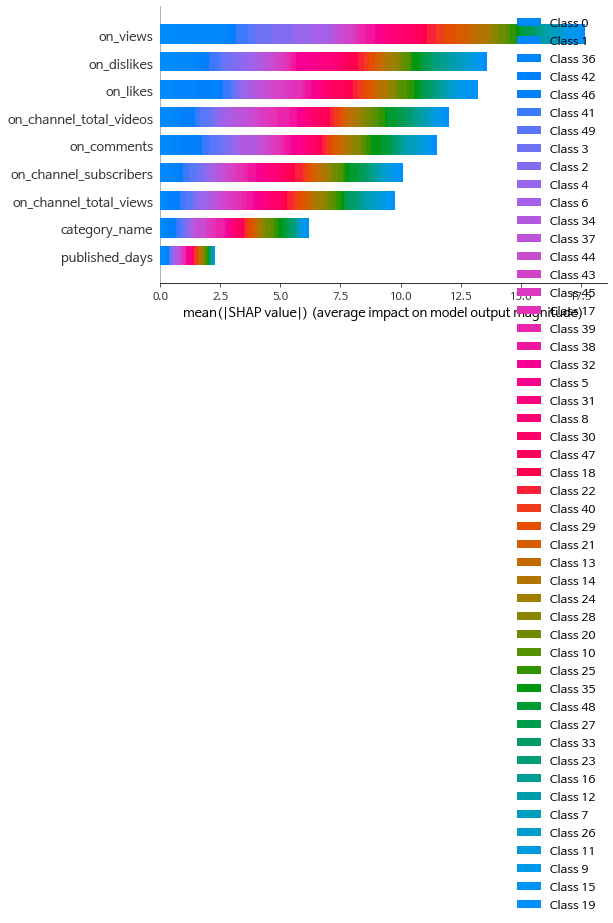

In [45]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_x)
shap.initjs()
shap.summary_plot(shap_values, test_x.iloc[:100],)